In [449]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [370]:
G = nx.DiGraph()

In [371]:
# Node labels
farms = ["F"+str(i) for i in range(1,11)]
custs = ["C"+str(i) for i in range(1,6)]
prods = ['P1', 'P2', 'P3']
dealer = "Dealer"

In [372]:
# Add nodes to network graph
G.add_nodes_from(farms)
G.add_node(dealer)
G.add_nodes_from(prods)
G.add_nodes_from(custs)

In [373]:
# Edges 
farm_dealer_edge_tuples =[(f,dealer) for f in farms]
dealer_prod_edge_tuples =[(dealer, p) for p in prods]
prod_cust_tuples = [('P1','C1'), ('P1','C2'), ('P1','C3'), ('P1','C4'), ('P2','C1'), ('P2','C2'), ('P2','C3'), ('P2','C4'), ('P3','C3'), ('P3','C4'), ('P3','C5')]

edges = farm_dealer_edge_tuples + dealer_prod_edge_tuples + prod_cust_tuples

In [374]:
# Connect nodes with edges
G.add_edges_from(edges)

In [375]:
# Set the type of product
prod_att = {'P1':{'eggs_per_box':6}, 'P2':{'eggs_per_box':12}, 'P3':{'eggs_per_box':30}}
nx.set_node_attributes(G, prod_att)

In [376]:
# Set type of customer
cust_att = {'C1':{'category':'grocery_store'}, 'C2':{'category':'supermarket'}, 'C3':{'category':'supermarket'}, 'C4':{'category':'hypermarket'}, 'C5':{'category':'supermarket'}} 
nx.set_node_attributes(G, cust_att)

In [377]:
# Add quantities supplied by farms
G['F1']['Dealer']['quantity']=100
G['F2']['Dealer']['quantity']=100
G['F3']['Dealer']['quantity']=100
G['F4']['Dealer']['quantity']=100
G['F5']['Dealer']['quantity']=100
G['F6']['Dealer']['quantity']=100
G['F7']['Dealer']['quantity']=100
G['F8']['Dealer']['quantity']=100
G['F9']['Dealer']['quantity']=100
G['F10']['Dealer']['quantity']=100

In [378]:
def get_total_supply(graph) -> np.int32:
    ''' Return the total number of eggs supplied by farms to dealer'''
    return np.sum([graph[f]['Dealer']['quantity'] for f in graph.predecessors('Dealer')])

In [418]:
supply_qty = get_total_supply(G)
supply_qty

1000

In [381]:
# Add distribution of eggs into product_type by dealer
G['Dealer']['P1']['quantity']=30
G['Dealer']['P2']['quantity']=30
G['Dealer']['P3']['quantity']=15

In [382]:
def get_packed_products(graph: nx.DiGraph) -> np.array:
    '''Returns the quanties of each product type'''
    return np.array([graph['Dealer'][p]['quantity'] for p in graph.successors('Dealer')])

In [398]:
def set_packed_products(graph: nx.DiGraph, arr: np.array) -> None:
    ''' Set packed quantites to values in array'''
    assert len([p for p in graph.successors('Dealer')]) == len(arr), "Array length mismatch!!"
    for product, val in zip(graph.successors('Dealer'), arr):
        graph['Dealer'][product]['quantity'] = val

In [422]:
# The quantities of each product types
packed_qty = get_packed_products(G)
packed_qty

array([30, 30, 15])

Supply constraint

(P1_eggs/box \* P1_qty) + (P2_eggs/box \* P2_qty) + (P3_eggs_box * P3_qty) $\leq$ Supply

In [423]:
def supply_check(graph: nx.DiGraph, qty_supplied: np.int, pack_qty: np.array) -> bool:
    ''' pack_qty: quanties packed of each product type by dealer
        qty_supplied: the total supply of eggs to dealer
        prod_capacity: the number of eggs/box for each product type'''
    global prods

    prod_capacity = np.array([graph.nodes[p]['eggs_per_box'] for p in prods])
    assert len(prod_capacity) == len(pack_qty), "Array length mismatch!!"
    
    return (sum(prod_capacity * pack_qty) <= supply_qty) and np.all(pack_qty >= 0)

In [421]:
supply_check(graph=G, qty_supplied=supply_qty, pack_qty=packed_qty)

True

In [545]:
def random_instantiate_packed_prods(total_supply: np.int, graph: nx.DiGraph) -> np.array:
    ''' Returns a array of random quantites for packed products that meet supply constraints'''
    global prods
    supply = total_supply.copy()
    prod_capacity = np.array([graph.nodes[p]['eggs_per_box'] for p in prods])
    array = np.zeros(prod_capacity.shape)
    while True:
        rand_arr = np.random.randint(0, 100, len(array))
        if sum(prod_capacity * rand_arr) <= supply:
            break
    return rand_arr

In [776]:
ripp = random_instantiate_packed_prods(total_supply=supply_qty, graph=G)
ripp

array([13, 14, 14])

In [777]:
type(ripp[0])

numpy.int32

In [764]:
type(ripp[0])

numpy.int32

In [544]:
prod_capacity = np.array([G.nodes[p]['eggs_per_box'] for p in prods])
sum(prod_capacity * ripp), supply_qty

(936, 1000)

In [388]:
# Set the demand for each product by every customer
G['P1']['C1']['demand']=20
G['P1']['C2']['demand']=20
G['P1']['C3']['demand']=10
G['P1']['C4']['demand']=10
G['P2']['C1']['demand']=20 
G['P2']['C2']['demand']=20
G['P2']['C3']['demand']=10
G['P2']['C4']['demand']=10
G['P3']['C3']['demand']=10
G['P3']['C4']['demand']=10
G['P3']['C5']['demand']=10

In [389]:
def get_demand(graph: nx.DiGraph) -> np.array:
    ''' Gets a demand array from graph'''
    global prods
    return np.array([graph[p][c]['demand'] for p in prods for c in graph.successors(p)]).astype(np.int64)   

In [390]:
demand = get_demand(G)
demand

array([20, 20, 10, 10, 20, 20, 10, 10, 10, 10, 10], dtype=int64)

In [391]:
# Add distribution of product types to customers
G['P1']['C1']['quantity']=10
G['P1']['C2']['quantity']=10
G['P1']['C3']['quantity']=5
G['P1']['C4']['quantity']=5
G['P2']['C1']['quantity']=10 
G['P2']['C2']['quantity']=10
G['P2']['C3']['quantity']=5
G['P2']['C4']['quantity']=5
G['P3']['C3']['quantity']=5
G['P3']['C4']['quantity']=5
G['P3']['C5']['quantity']=5

In [392]:
def get_allocated_quantities(graph: nx.DiGraph) -> np.array:
    ''' Returns an array with the allocated quantities'''
    global prods
    return np.array([graph[p][c]['quantity'] for p in prods for c in graph.successors(p)]).astype(np.int64)

In [368]:
def set_allocated_quantities(graph: nx.DiGraph, vec: np.array) -> nx.DiGraph:
    ''' Replaces the allocated quantites of products by a values in vec'''
    global prods
    for p in prods:
        for c, v in zip(graph.successors(p), vec):
            graph[p][c]['quantity']= v        


In [717]:
alloc_qty = get_allocated_quantities(G)
alloc_qty

array([10, 10,  5,  5, 10, 10,  5,  5,  5,  5,  5], dtype=int64)

In [719]:
alloc_qty[0:4]

array([10, 10,  5,  5], dtype=int64)

In [396]:
def demand_check(vec: np.array, demand_vec: np.array) -> bool:
    ''' Checks to see that the allocated quantities is less than demand
        and greater than zero '''
    return np.all(alloc_qty <= demand) and np.all(alloc_qty >= 0)

In [765]:
demand_check(alloc_qty, demand)

True

In [781]:
def random_instantiate_allocated_qty(graph: nx.DiGraph, prod: str, supply_prod: np.int) -> np.array:
    
    demand = np.array([graph[prod][c]['demand'] for c in G.successors(prod)]).astype(np.int)
    supply = supply_prod.copy()
    arr = np.zeros(demand.size)
    for i, d in enumerate(demand):
        try:
            r = np.random.randint(0, min(d, supply))
            arr[i] = r
            supply -= r
        except ValueError:
            z = 0
            arr[i] = z
    return arr

In [799]:
random_instantiate_allocated_qty(graph=G, prod=prods[0], supply_prod=ripp[0])

array([2., 4., 5., 1.])

In [805]:
vec = np.concatenate([random_instantiate_allocated_qty(graph=G, prod=p, supply_prod=s) for p,s in zip(prods, ripp)])

In [866]:
vec

array([6., 3., 2., 1., 6., 2., 3., 1., 6., 1., 6.])

In [865]:
demand

array([20, 20, 10, 10, 20, 20, 10, 10, 10, 10, 10], dtype=int64)

In [808]:
demand_check(vec, demand)

True

In [811]:
[[G[prods[0]][c]['demand'] for c in G.successors(prods[0])] for p in prods]

[[20, 20, 10, 10], [20, 20, 10, 10], [20, 20, 10, 10]]

In [895]:
def supply_check_alloc(vec: np.array, packed_prod: np.array, graph: nx.DiGraph) -> bool:
    ''' Check to see if the vec meets packed products constraint'''
    global prods
    # Get the cumulative sum of index positions [start:end] of the products and customers -> [0,4,8,11] 
    inds = np.cumsum(np.insert([len([graph[p][c]['demand'] for c in graph.successors(p)]) for p in prods],0,0))
    assert len(inds)-1 == len(packed_prod), 'Length mismatch!'
    # Sum of values in the index positons together
    totals = [np.sum(vec[inds[i]:inds[i+1]]) for i, pp in enumerate(packed_prod)] 
    return np.all(totals <= packed_prod) and np.all(vec >= 0)

In [897]:
supply_check_alloc(vec=vec, packed_prod=ripp, graph=G)

True

In [894]:
np.cumsum(np.insert([len([G[p][c]['demand'] for c in G.successors(p)]) for p in prods],0,0))

array([ 0,  4,  8, 11], dtype=int32)

In [243]:
# Get edge labels for plotting
edge_att = nx.get_edge_attributes(G, 'quantity')

In [244]:
#Node positions on graph
sc_pos = {'F1': (1, 10), 'F2': (1, 9), 'F3': (1, 8), 'F4': (1, 7), 'F5': (1, 6), 'F6': (1, 5), 'F7': (1, 4), 'F8': (1, 3), 'F9': (1, 2),'F10': (1, 1), dealer:(5,5), 'P1':(7,7), 'P2':(7,5), 'P3':(7,3), 'C1': (9,9), 'C2': (9,7), 'C3': (9,5), 'C4': (9,3), 'C5': (9,1) }

In [245]:
# Color the nodes
val_map = {'Dealer': 'pink',
        'F1':'limegreen','F2':'limegreen','F3':'limegreen','F4':'limegreen','F5':'limegreen',
        'F6':'limegreen','F7':'limegreen','F8':'limegreen','F9':'limegreen','F10':'limegreen',
        'C1':'skyblue','C2':'skyblue','C3':'skyblue','C4':'skyblue', 'C5':'skyblue',
        'P1':'salmon','P2':'salmon','P3':'salmon'}

col = [val_map.get(node_col,'black') for node_col in G.nodes()]

In [246]:
# Size the nodes
val_map_size = {'Dealer': 3000,
        'F1':500,'F2':500,'F3':500,'F4':500,'F5':500,'F6':500,'F7':500,'F8':500,'F9':500,'F10':500,
        'C1':500,'C2':500,'C3':500,'C4':500, 'C5':500,
        'P1':500,'P2':500,'P3':500}
size = [val_map_size.get(node_col,'black') for node_col in G.nodes()]

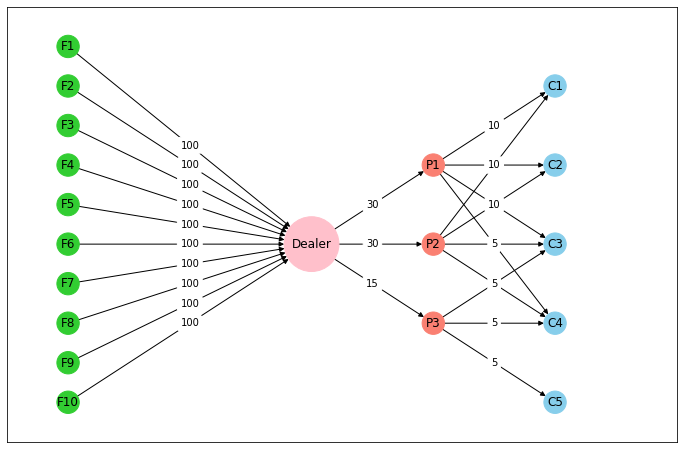

In [247]:
# Draw graph
fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx(G, pos=sc_pos, node_size = size, node_color= col, arrows=True)
nx.draw_networkx_edge_labels(G, pos=sc_pos, edge_labels=edge_att, rotate=False)
ax.set_xlim(0,11)
ax.set_ylim(0,11)
# plt.savefig('sc_graph')
plt.show()